Installing and importing modules

In [1]:
!pip install opencv-python matplotlib imageio gdown tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.79.0 which is incompatible.
tfx-bsl 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
apache-beam 2.44.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.


In [2]:
!pip install -U --no-cache-dir gdown --pre

In [3]:
import os
import cv2 # preprocessing data
import tensorflow as tf # training model
import numpy as np # data manipulation
from typing import List
from matplotlib import pyplot as plt # post processing ploting
import imageio # numpy => GIF

In [4]:
# limit memory to prevent data leak

# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   try:
#     # Currently, memory growth needs to be the same across GPUs
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#     print(e)
  

Data Loading Functions

In [5]:
import gdown

In [6]:
url = 'https://drive.google.com/u/0/uc?id=1o0RsN-LQsu703DIu0o-aw3Uh9SRpBz_6&export=download'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From: https://drive.google.com/u/0/uc?id=1o0RsN-LQsu703DIu0o-aw3Uh9SRpBz_6&export=download
To: /kaggle/working/data.zip
100%|██████████| 423M/423M [00:10<00:00, 41.3MB/s] 


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [7]:
def load_video(path:str) -> List[float]:
  cap = cv2.VideoCapture(path)
  frames = []
  for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
    ret,frame = cap.read()
    frame = tf.image.rgb_to_grayscale(frame)
    frames.append(frame[190:236,80:220,:])
    # selecting the lip area from the whole image statically
  cap.release()
  # standadizing the images
  mean = tf.math.reduce_mean(frames)
  std = tf.math.reduce_std(tf.cast(frames,tf.float32))
  return tf.cast((frames - mean),tf.float32) /std 


In [8]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [9]:
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [10]:
# converting char to num inorder to tokenize the dataset
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab,oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(),oov_token="",invert=True
)
print(f"The vocabulary is : {char_to_num.get_vocabulary()}\n"
      f"(size = {char_to_num.vocabulary_size()}")


The vocabulary is : ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ']
(size = 40


In [11]:
char_to_num(["a","b","d"]) # encoding it to [1,2,4]

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([1, 2, 4])>

In [12]:
num_to_char([1,2,4]) # decoding it back to a,b,d

<tf.Tensor: shape=(3,), dtype=string, numpy=array([b'a', b'b', b'd'], dtype=object)>

In [13]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [14]:
def load_data(path: str): 
  path = bytes.decode(path.numpy())
  file_name = path.split('/')[-1].split(".")[0]
  # file_name = tf.convert_to_tensor(path).numpy().decode('utf-8').split("\\")[-1].split('.')[0]
  
  video_path = os.path.join('data','s1',f"{file_name}.mpg")
  alignment_path = os.path.join("data","alignments",'s1',f"{file_name}.align")
  frames = load_video(video_path)
  alignments = load_alignments(alignment_path)
  
  return frames,alignments

In [15]:
test_path = './data/s1/bbal6n.mpg'

In [16]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split("\\")[-1].split('.')[0]

''

In [17]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

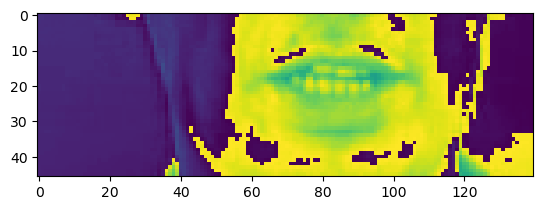

In [18]:
frame = frames[40].numpy().squeeze()
plt.imshow(frame);

In [19]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [20]:
# wrapper used for string input data pipelines
def mappable_function(path:str) -> List[str]:
  result = tf.py_function(load_data,[path],(tf.float32,tf.int64))
  return result

Create Data Pipeline






In [21]:
import tensorflow as tf
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(100,reshuffle_each_iteration=False)
data = data.map(mappable_function)

# padding alignments to 40
data = data.padded_batch(4,padded_shapes=([75,None,None,None],[40])) 
data = data.prefetch(tf.data.AUTOTUNE)


In [22]:
print(f"Data size after spliting into batches : {data.cardinality().numpy()}")

Data size after spliting into batches : 250


In [23]:
len(frames)

75

In [24]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [25]:
test = data.as_numpy_iterator()

In [26]:
val = test.next(); val[0]

array([[[[[ 1.4009043 ],
          [ 1.4009043 ],
          [ 1.4009043 ],
          ...,
          [ 9.923072  ],
          [ 9.923072  ],
          [ 9.144792  ]],

         [[ 1.4009043 ],
          [ 1.4009043 ],
          [ 1.4009043 ],
          ...,
          [ 9.495018  ],
          [ 9.378276  ],
          [ 8.794566  ]],

         [[ 1.2452482 ],
          [ 1.2452482 ],
          [ 1.2452482 ],
          ...,
          [ 9.22262   ],
          [ 9.495018  ],
          [ 9.495018  ]],

         ...,

         [[ 0.89502215],
          [ 0.89502215],
          [ 0.89502215],
          ...,
          [ 9.728502  ],
          [ 9.728502  ],
          [ 9.728502  ]],

         [[ 0.89502215],
          [ 0.89502215],
          [ 0.89502215],
          ...,
          [ 9.650674  ],
          [ 9.689588  ],
          [ 9.689588  ]],

         [[ 0.89502215],
          [ 0.89502215],
          [ 0.89502215],
          ...,
          [ 9.689588  ],
          [ 9.689588  ],
          

In [27]:
imageio.mimsave('./animation.gif',val[0][0],fps=10)

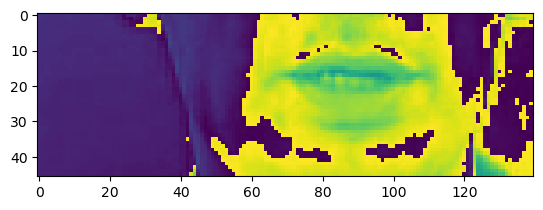

In [28]:
# plt.imshow(val[0][1][35].squeeze());
plt.imshow(val[0][0][35].squeeze());

In [29]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place green by r two please'>

Design the Deep Neural Network

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers.legacy import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [31]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = Sequential()
    model.add(Conv3D(128,3,input_shape=(75,46,140,1),padding='same')) # padding = same means ouput shape is preserved
    model.add(Activation('relu'))
    model.add(MaxPool3D((1,2,2)))

    model.add(Conv3D(256,3,padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1,2,2)))

    model.add(Conv3D(75,3,padding="same"))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1,2,2)))

    model.add(TimeDistributed(Flatten())) # 75 inputs and 75 outputs


    model.add(Bidirectional(LSTM(128,kernel_initializer="Orthogonal",return_sequences=True)))
    model.add(Dropout(.5))

    model.add(Bidirectional(LSTM(128,kernel_initializer="Orthogonal",return_sequences=True)))
    model.add(Dropout(.5))

    model.add(Dense(char_to_num.vocabulary_size()+1,kernel_initializer="he_normal",activation='softmax'))

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [33]:
5*17*75

6375

In [34]:
yhat = model.predict(val[0])
# prediction before training 
# https://stackoverflow.com/questions/58359153/cancellederror-derived-recvasync-is-cancelled

1/1 [==============================] - 10s 10s/step


In [35]:
# tf.convert_to_tensor(val)

In [36]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'nnn222222222222222222222222222222222222222222222222222222222222222222222222'>

In [37]:
model.input_shape

(None, 75, 46, 140, 1)

In [38]:
model.output_shape

(None, 75, 41)

Setup Training options and Train

In [39]:
# Taken from Automatic Speech recognision model
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

#     print(f"y_true : {y_true}")
#     print(f"batch_len : {batch_len}")
#     print(f"label_length : {label_length}")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [40]:
def scheduler(epoch,lr):
  if epoch<30:
    return lr
  else:
    return lr* tf.math.exp(-0.1)

In [41]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
#     def on_epoch_end(self, epoch, logs=None) -> None:
#         data = self.dataset.next()
#         yhat = self.model.predict(data[0])
#         decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
#         for x in range(len(yhat)):           
#             print('Original :', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
#             print('Prediction :', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
#             print('-'*100)

In [42]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss=CTCLoss) # run_eagerly=True

In [43]:
checkpoint_callback = ModelCheckpoint(os.path.join("models","checkpoint"),monitor="loss",save_weights_only=True)

In [44]:
schedule_callback = LearningRateScheduler(scheduler)

In [45]:
# Added for split 
train = data.take(225)
test = data.skip(225)
example_callback = ProduceExample(data)


In [46]:
print(f"batch Training data :{train.cardinality().numpy()}")
print(f"batch Testing data :{test.cardinality().numpy()}")

batch Training data :225
batch Testing data :25


In [47]:
model.fit(train, validation_data=test, epochs=5, callbacks=[checkpoint_callback, schedule_callback, example_callback])



Epoch 1/5
154/225 [===================>..........] - ETA: 1:45 - loss: 98.6291

[mpeg1video @ 0x7fd6340a3a40] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd6340a3a40] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 91.8865

[mpeg1video @ 0x7fd58c008980] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd58c008980] Warning MVs not available


225/225 [==============================] - 593s 3s/step - loss: 91.8865 - val_loss: 73.3713 - lr: 1.0000e-04
Epoch 2/5
190/225 [========================>.....] - ETA: 51s - loss: 74.5999

[mpeg1video @ 0x55d888c00ec0] ac-tex damaged at 22 17
[mpeg1video @ 0x55d888c00ec0] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 74.0632

[mpeg1video @ 0x7fd5200b6600] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd5200b6600] Warning MVs not available


225/225 [==============================] - 565s 3s/step - loss: 74.0632 - val_loss: 68.6038 - lr: 1.0000e-04
Epoch 3/5
210/225 [===========================>..] - ETA: 22s - loss: 70.6360

[mpeg1video @ 0x7fd58c0b8fc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd58c0b8fc0] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 70.5936

[mpeg1video @ 0x7fd5942e8440] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd5942e8440] Warning MVs not available


225/225 [==============================] - 566s 3s/step - loss: 70.5936 - val_loss: 65.1724 - lr: 1.0000e-04
Epoch 4/5
 71/225 [========>.....................] - ETA: 3:50 - loss: 68.4416

[mpeg1video @ 0x7fccae52ef00] ac-tex damaged at 22 17
[mpeg1video @ 0x7fccae52ef00] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 67.6244

[mpeg1video @ 0x7fccc9c9c9c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7fccc9c9c9c0] Warning MVs not available


225/225 [==============================] - 569s 3s/step - loss: 67.6244 - val_loss: 64.0918 - lr: 1.0000e-04
Epoch 5/5
110/225 [=============>................] - ETA: 2:50 - loss: 65.6368

[mpeg1video @ 0x7fd62c0a4640] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd62c0a4640] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 65.2996

[mpeg1video @ 0x7fd62c1a0c80] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd62c1a0c80] Warning MVs not available


225/225 [==============================] - 562s 3s/step - loss: 65.2996 - val_loss: 61.8580 - lr: 1.0000e-04
